<center><h1>Report of Project 3: "Implementation and evaluation of Otsu Thresholding"</h1></center>

*Elizaveta Chernova, Veronika Schuler, Laura Wächter, Hannah Winter*

<h3>Abstract</h3>
<div style="text-align: justify">
Thresholding is a useful method that is frequently used in the context of
image segmentation.
In this project, we used Otsu's thresholding algorithm in order to find the optimal threshold value,
that optimizes the image segmentation.
This algorithm will be applied to a number of pictures from different datasets.
To improve the results, several preprocessing methods (mainly filters) are used.
The final segmentations are compared to reference pictures and evaluated with several methods.
The datasets are characterized by different features, like reflections or low contrast.
For this reason, it is likely that different preprocessing methods will lead to the optimal result.
Our overall analysis confirms this hypothesis.
</div>

<h3>Table of contents</h3>

...

<h3>Introduction</h3>
<div style="text-align: justify">
In computer vision, image segmentation is used for a variety of purposes. In general, image segmentation describes the process of dividing a digital image into multiple segments
 to simplify the image. These simplified images can be used for further analyses. In the field of medicine or biology,
image segmentation is often used to locate tumors and other pathologies or to measure tissue volume.
Segmentations of images displaying cell nuclei are often used as an input for
algorithms that measure the number or size of the cell nuclei. If time-laps images are used,
it is also possible to track the cell movement.
<br>
Thresholding is a simple method of image segmentation. Based on a single intensity value, the image is divided into two segments:
 Pixels with with higher intensities and pixels with lower intensities than the threhold value are distinguished.
 In order to find the threshold value, that results in the best possible image segmentation we use "Otsu's Thredholding" algorithm.
<br>
In the course of the project, we will work with three different data sets,
 each of which will present us with different challenges:
 Low contrast, noise and reflections make it difficult to distinguish the cells and the background.
 In order to achieve good results despite these difficulties, different preprocessing methods are applied to the images prior to the image segmentation.
 Due to the differences between the datasets we hypothesize that different preprocessing methods will result in the optimal segmentation for every dataset.
<br>
The accuracy of the obtained segmented image is evaluated by using the dice score as well as the median surface distance
and the Hausdorff distance. These metrics compare the obtained segmentation to a reference segmentation image.
Beyond that, we implemented a cell counting algorithm in order to give a meaning to the segmented images.



<h3>Description of the datasets</h3>

<h5>N2DH-GOWT1 cells</h5>
The dataset N2DH-GOWT1 of the cell tracking challenge (Bártová et al., 2011) contains images of GFP-GOWT1 mouse
embryonic stem cells that have been derived with time-lapse confocal microscopy with a Leica TCS SP5 microscope.
The varying brightness of the cells makes it hard to distinguish all the cells from the background.

<h5>N2HL-HeLa cells</h5>
The dataset N2DL-HeLa of the cell tracking challenge (Neumann et al., 2010) contains images of human epithelial cells
of cervical cancer. Those images have been derived with an Olympus IX81 microscope used for live imaging of
fluorescently labelled chromosomes. The challenge in these images is the variety of brightness of the cells.

<h5>NIH3T3 cells</h5>
The dataset NIH3T3 (Coelho et al., 2009) contains images of several mouse embryonic fibroblast cells. These images
have also been derived with fluorescence microscopy images and the difficulty in segmenting these images mainly
lies in the bright light spots, probably from the used microscope, that makes it difficult for the algorithm to choose
a threshold between the brightness of the cells and the background and not between the brightness of light spots
and the cells.
</div>



In [2]:
# Import of the Modules
from nuclei_segmentation import metrics, complete_analysis, visualisation, evaluation, otsu
from skimage import io
from matplotlib import pyplot as plt
from skimage.filters import threshold_otsu
import numpy as np
import pathlib as pl
import json
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

<div style="text-align: justify">
    
<h2>Methods</h2>
The following preprocessing methods are thought to improve the results of  Otsu's thresholding algorithm by reducing noice and other disruptive factors in the input images. The accuracy of the final segmentation is evaluated by different evaluation measures.


<h3>Preprocessing</h3>
<h4>Gaussian filter</h4>
The intent of the Gaussian filter is to blur the images and therefore to reduce noise. In the optimal case, this filter helps to reduce the reflections in the images, that might disturb the thresholding algorithm. The Gaussian kernel, that is used to compute the weighted average of the pixels, has the shape of the 2D zero-mean Gaussian function $G_\sigma$ with standard deviation $\sigma$. The higher $\sigma$ is set, the stronger is the blurring effect in the respective image.

\begin{align*}
G_\sigma(x,y) = \frac{1}{σ^2 2π}  e^\frac {-(x^2 + y^2)}{2σ^2} \\
\end{align*}

<h4>Median filter</h4>
The Median filter is a non linear filter, that is often used to reduce noise in images.
The gray-value of all pixels in a pixel neighborood of a defined size are ranked by size. The intensity value of the central pixel is then substituted through the median of its neighbourhood.
This filter is particularly useful to reduce salt and pepper noise in images.
Compared to the Gaussian filter, a useful feature of the Median filter is that edges are preserved while the overall noise is reduced. 

<h4>Histogram stretching</h4>
Histogram stretching is a technique that aims to enhance the contrast of an image and might therefore help to optimize the segmentation results. The range of intensity values is 'stretched' to a desired minimal an maximal intensity value.
The first step is to take all intensity values in the image and to select the minimal intesity value $c$ and the maximal intensity value $d$ of the input image as the $2nd$ and $98th$ percent quantiles. The lower and upper pixel intensity limits $a$ and $b$ to which the image is stretched are often times the minimum and the maximum pixel values of the respective image type. Hence, for 8 bit gray-level images $a$ is set to $0$ whereas $b$ is set to $255$. These values must be adjusted accordingly for other image types. The pixel intensity of the output image $P_{out}$ is calculated from the pixel intensity $P_{in}$ of the input image based on a linear function.

\begin{align*}
P_{out} = (P_{in} - c) \frac{(b-a)}{(d-c)} + a
\end{align*}
<br>

<h4>Otsu's Thresholding</h4>
In order to adequately seperate objects from the backround it is important to select an optimal threshold value.
In the optimal case, the image histogram shows a bimodal distribution.
 In this scenario, the threshold could simply be selected at the bottom of the valley between the two intensity peaks representing foreground and background.
 However, in most cases it is not obvious where the optimal threshold value lies. In this case, Otsu's thresholding method allows us to compute the best threshold value automatically.
  The algorithm computes the inbetween class variance $\sigma_B$ for all possible threshold values. Every threshold value seperates all pixels in the image in two classes:
  Pixels with a lower intensity and pixels with a higher intensity than the threshold value.
  The between-class variance $\sigma_B$ is caluclated from the probability of class occurrence $\omega$, the mean intensity values $\mu$ of both pixel classes as well as the total intensity value variance $\mu_T$.
   The intensity level that maximizes the between-class variance is selected as the optimal threshold value.

\begin{align*}
   σ_B^2 = ω_1(µ_1 - µ_T)^2 + ω_2(µ_2 - µ_T)^2
\end{align*}

In order to recieve a segmented, binary image, the pixel intensity $g(x,y)$ has to be changed accordingly. Pixels with a lower or equal intensity value than the optimal threshold $k$ are set to $0$. Analogous to this, all pixels with a higher intensity value than the threshold are set to $1$.

\begin{align*}
     g_{segmentation} (x,y)=\left\{\begin{array}{ll}0 & if & g(x,y) \leq k  \\
     1 & if & g(x,y) > k\end{array}\right.
\end{align*}

<h4>Two-level Otsu</h4>
Otsu's thresholding method can easily be extended to multithresholding problems. Regarding our topic, this approach might be useful to reduce bright reflection spots, that might otherwise be recognized as cell nuclei by the algorithm. Therefore, the idea is to set two threshold values: The higher threshold value seperates the reflections from the remaining image whereas the lower threshold value seperates the cell nuclei from the background. The computation of two threshold values results in three different pixel classes. Analogous to the one-level algorithm, the optimal threshold values are computed by minimizing the inbetween-class vrinace between the classes.

\begin{align*}
   σ_B^2 = ω_1(µ_1 - µ_T)^2 + ω_2(µ_2 - µ_T)^2 + ω_3(µ_3 - µ_T)^2
\end{align*}

Next, all pixels having a higher intensity than the upper threshold value (ideally the reflections in the image) are set to $0$. All pixels having a lower or equal intensity than the lower threshold value are also set to $0$. The remaining pixels are set to $1$.

<h3>Evaluation</h3>
In order to evaluate the result of the image segmentation based on Otsu's thresholding algorithm, the segmentation are compared with reference images. For every picture in the dataset there is a binary 'Ground truth' image, that displays an accurate segmentaion of the respective image. The correspondence of our final segmentation and the 'Ground truth' image can be evaluated by using various metrics.

<h4>Dice Score</h4>
The Dice score (DSC) is often used in order to assess the performance of image segmentation algorithms. The Dice score is a measure of similarity between the segmented image and the 'Ground truth'. Its value corresponds to the size of overlap between all pixels with intensity $1$ in the segmented picture $S$ and in the 'Ground truth' image $G$.

\begin{align*}
    DSC = \frac{2\cdot |S\cap G|}{|S|+|G|} \\
\end{align*}

The Dice score lies within the interval $[0,1]$. In the event of a complete match between the segmented image and the 'Ground truth' image, the obtained Dice score is $1$. In the opposite case, the obtained Dice Score is $0$. In general, higher Dice scores indicate a more precise image segmentation.

<h4>Surface Distances</h4>
Surface distances are another way to evaluate an image segmentation method by comparing the segmented image with the 'Ground truth' image. The distance $D$ between a point $s$ in the set of pixels $S$ (all pixels with intensity $1$ in the segmented image) to the set of pixels $G$ (all pixels with intensity $1$ in the 'Ground truth' image) corresponds to the minimal euclidean distance between $s$ and all pixels $g$ in $G$:

\begin{align*}
    D(s, G) = min \{d(s - g)| g \in G\}
\end{align*}

This distance is computed for every pixel in both sets $S$ and $G$, whereby the total distances $D(S,G)$ and $D(G,S)$ (two distance vectors) between the pixel sets are obtained. The Mean surface distance (MSD), as the name implies, is the average surface distance between the two pixel sets by adding up all distances and dividing by the total number of pixels $n_S$ and $n_G$ in both pixel sets. For smaller MSD values the segmentation is more accurate.

\begin{align*}
    MSD = \frac{1}{n_S + n_G}   \left(\sum_{p=1}^{n_S} D(s,G) + \sum_{g=1}^{n_G}  D(g,S)\right)
\end{align*}

By contrast, the Hausdorff distance (HD) named after the German mathematican Felix Hausdorff is the maximal surface distance between the two pixel sets. For smaller HD values, the segmentation is more accurate.

\begin{align*}
    HD = max\{D(S,G),D(G,S)\}
\end{align*}

In general, the Hausdorff distance is very sensitive to outliers and therefore not recommended if outliers are likely.

<h3>Cell counting</h3>
The basic idea of the cell counting algorithm is to identify all pixels that form the outline of the segmented cells.
 These ‘border pixels’ are located by identifying intensity changes from zero to one in the segmented image.
 By grouping adjacent border pixels, all pixels belonging to the same shape are combined into groups.
 The count of the obtained groups matches the count of cells in the image. The picture below visualizes the located 'outline pixels'.
</div>

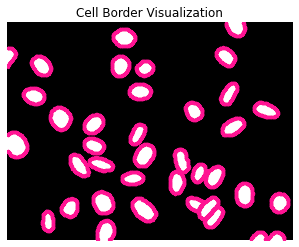

In [2]:
cell_counting_example = io.imread(str(pl.Path('./Data/NIH3T3/gt/42.png')))
border_pixels = metrics.find_border(cell_counting_example)
visualisation.border_image(cell_counting_example, border_pixels);

<h2>Outcomes</h2>
<br>
Five different preprocessing methods were applied to the images: Histogram stretching, the gaussian and median filter individually as well as two combinations: The gaussian filter and the median filter were each combined with histogram stretching. The results are precalculated and saved in .json files but if desired, they can be recalculated in a few hours.

In [7]:
# Set to True if one level recalculations are desired (requires a few hours...)
complete_analysis.recalculation_desired(recalculate_data=False, path_to_data="Results/values.json")
# Set to True if two level recalculations are desired (requires a few hours...)
complete_analysis.recalculation_desired(recalculate_data=False, path_to_data="Results/two_lvl.json")

The optimal preprocessing method for each dataset are determined based on the mean Dice Scores as well as the mean surface distances of every dataset. 
Also the distribution of the different evaluation scores is taken into account. In the following, the results for each dataset are discussed individually.

**Dataset 1**

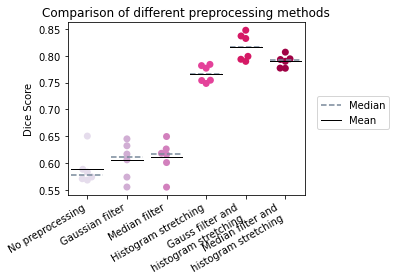

In [4]:
visualisation.comparison_swarmplot(complete_analysis.get_one_lvl_dice_scores(data_one_level, dataset = "N2DH-GOWT1"))

Results:

After applying all sorts of pre-processing methods, the highest dice score, with 81.7 %, was obtained when
using the median filter and histogram stretching. Also here all sorts of pre-processing methods were used. Finally, the best median surface distance value was obtained
when using only histogram stretching. The obtained value is 2.282.

Discussion

The images in this dataset were very low in contrast which made it hard to distinguish the all cell nuclei from
the background.
To solve this particular problem we decided to use histogram stretching. In order to do that, the minimum and
the maximum intensity values of the original image are taken and remapped to 0 or 1. All the values in between are
recalculated based on a linear function. After that, the median filter was implemented. The median takes the median
intensity of the central pixel and the surrounding pixels in the neighborhood by weighing each pixel the same.
As described above, histogram stretching increases the contrast of the cell nuclei images.


**Dataset 2**

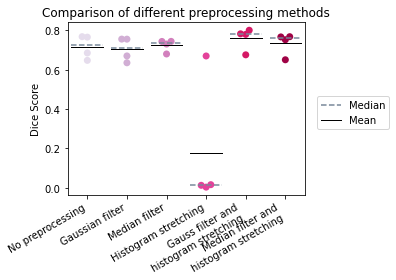

In [5]:
visualisation.comparison_swarmplot(complete_analysis.get_one_lvl_dice_scores(data_one_level, dataset = "N2DL-HeLa"))

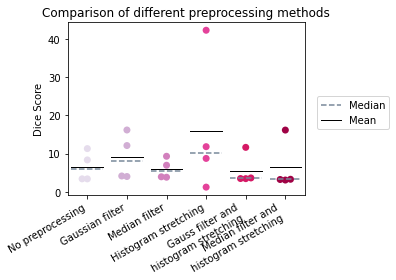

In [6]:
visualisation.comparison_swarmplot(complete_analysis.get_one_lvl_msd(data_one_level, dataset = "N2DL-HeLa"))

Results

We used all kinds of combinations of pre-processing functions on N2DL-HeLa cells. The dice score tells that a combination
out of median filter and histogram stretching works best, with a mean value of 76 percent correctness. The mean value
of all mean surface distance values is 5.527, which is quite low compared to the msd values of other datasets and
confirms this pre-processing combination. Only the hausdorff value is 119,439 which is also good compared to other
datasets but suggests a different pre-processing method to be the best choice for this kind of picture: the gaussian
filter.

Discussion

The challenge in images of N2DL- HeLa cells is the strongly varying brightness. The median filter makes the image look
smoother and the histogram stretching makes the contrast between foreground and background stronger. Therefore, the
histogram of intensity levels has a deeper and sharper valley and it will be easier for Otsu’s algorithm to find the
correct threshold. It does make sense to choose those pre-processing methods. There is only a correctness of 76 percent,
because there are still cells with very low intensity values that are excluded as background and therefore deviate from
the ground truth images.



**Dataset 3**
<br>
Results
<br>
Since a big challenge of the NIH3T3 dataset are reflections, we applied both one- and two-level Otsu thresholding on them. Moreover, we tested the different preprocessing methods.
Dice Scores of images segmented with one-level Otsu thresholding were bimodally distributed, as shown in the following figure. 


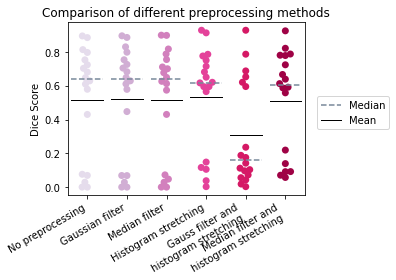

In [7]:
visualisation.comparison_swarmplot(complete_analysis.get_one_lvl_dice_scores(data_one_level, dataset = "NIH3T3"))

The preprocessing strategy that resulted in the highest mean Dice Score (0.533) is histogram stretching.

Dice Scores with use of the two-level Otsu thresholding had a relatively big variance. The best Dice Score (0.577) resulted by images that were preprocessed using median filter as shown in the following figure.

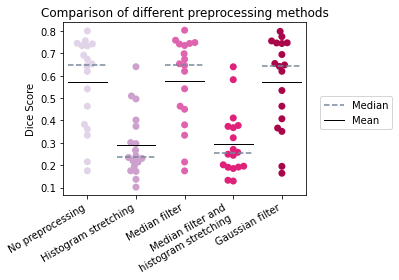

In [8]:
scores = complete_analysis.get_all_two_level_results(str(pl.Path("Results/two_lvl.json")), "NIH3T3")
visualisation.comparison_swarmplot(scores,
                                 x_label=["No preprocessing", "Histogram stretching","Median filter",
                                          "Median filter and\nhistogram stretching", "Gaussian filter"])

In both cases of one- and two-level Otsu thresholding the mean and the median values were significantly different, which means that the distribution of the Dice Score values is not symmetrical.

*Discussion*
<br>
As mentioned in the results, the distribution of Dice Score values after one-level Otsu segmentation was bimodal. The reason for that is that not all images in the dataset have reflections. Those without reflections are successfully segmented when using one-level Otsu thresholding. The two-level Otsu on those images on the other side is not needed and sometimes contra-productive, which results in the high variance of the results.

The following image shows results of the segmentation on an image with a few really bright reflections. Because of the intensity values in the reflection regions are much higher than the average image intensity, the one-level Otsu algorithm set the threshold value too high. Therefore most of the cell nuclei were not detected in the segmentation.

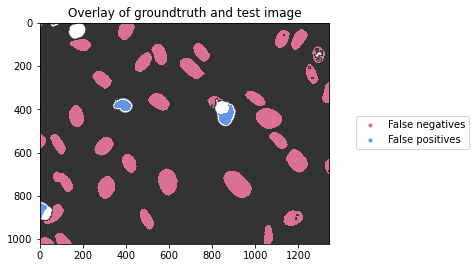

In [3]:
segmentation_one_level = otsu.complete_segmentation(io.imread(str(pl.Path('Data/NIH3T3/img/dna-47.png'))))
ground_truth = io.imread(str(pl.Path('Data/NIH3T3/gt/47.png')))
visualisation.overlay(segmentation_one_level,ground_truth)

In [ ]:
#Histogram?

The same image segmented with two-level Otsu showed to be much more succesful as depicted in the image below. The values above the higher threshold were assigned to background and the values between the two thresholds were assigned to the cell nuclei

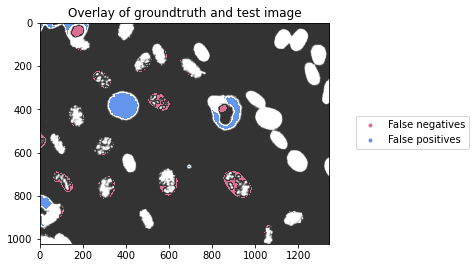

In [5]:
segmentation_two_level = otsu.complete_segmentation_twolevel(io.imread(str(pl.Path('Data/NIH3T3/img/dna-47.png'))))
visualisation.overlay(segmentation_two_level,ground_truth)

## Cell nuclei counting

### Results

The cell nuclei counting algorithm was tested on the ground truth images from N2DH-GOWT1 and N2DL-HeLa datasets. The single cell nuclei in the ground truth images in these datasets have different intensities. Therefore it is possible to extract the ground truth number of cell nuclei from the images.

The results are presented in the following tables.

In [6]:
with open(str(pl.Path('Results/cell_counting_results.json')), "r") as file:
    cell_counting_results = json.load(file)
    
table_GOWT1 = pd.DataFrame.from_dict(cell_counting_results["N2DH-GOWT1"])
table_GOWT1 = table_GOWT1.set_axis(["man_seg01.tif", "man_seg21.tif", "man_seg31.tif", 
                                    "man_seg39.tif", "man_seg52.tif", "man_seg72.tif"], axis = 0)
table_GOWT1.style.set_caption('Table 1: Results of the cell counting on the N2DH-GOWT1 dataset.')

,Calculated number,Ground truth number,Absolute difference,Relative difference
man_seg01.tif,24,23,1,0.043478
man_seg21.tif,23,24,-1,-0.041667
man_seg31.tif,24,22,2,0.090909
man_seg39.tif,23,25,-2,-0.080000
man_seg52.tif,30,30,0,0.000000
man_seg72.tif,28,28,0,0.000000


In [7]:
table_HeLa = pd.DataFrame.from_dict(cell_counting_results["N2DL-HeLa"])
table_HeLa = table_HeLa.set_axis(["man_seg13.tif", "man_seg52.tif", "man_seg75.tif", "man_seg79.tif"], axis = 0)
table_HeLa.style.set_caption('Table 2: Results of the cell counting on the N2DL-HeLa dataset.')

,Calculated number,Ground truth number,Absolute difference,Relative difference
man_seg13.tif,58,59,-1,-0.016949
man_seg52.tif,107,109,-2,-0.018349
man_seg75.tif,365,349,16,0.045845
man_seg79.tif,329,342,-13,-0.038012


In [8]:
mean_error = np.abs(np.mean(cell_counting_results["N2DL-HeLa"]["Relative difference"] 
                            + cell_counting_results["N2DH-GOWT1"]["Relative difference"]))
standard_deviation =np.abs(np.std(cell_counting_results["N2DL-HeLa"]["Relative difference"] 
                                  + cell_counting_results["N2DH-GOWT1"]["Relative difference"]))
print("Relative error (datasets combined): {} +/- {}".format(mean_error, standard_deviation))

Relative error (datasets combined): 0.001474351498372345 +/- 0.04737068686901992


### Discussion

Our algorithm could correctly calculate the cell nuclei number in only 2 of 10 images. The relative error did not exceed 10% and 5% when applied to the N2DH-GOWT1 and on the N2DL-HeLa datasets respectivly. By analyzing the images we determined the possible causes of the errors. Characteristic examples are shown below.

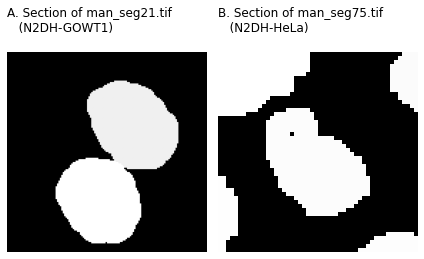

In [9]:
img_GOWT1 = io.imread(str(pl.Path('Data/N2DH-GOWT1/gt/man_seg21.tif')))
img_HeLa = io.imread(str(pl.Path('Data/N2DL-HeLa/gt/man_seg75.tif')))

visualisation.two_img_plot(img_GOWT1[660:800, 800:940], img_HeLa[610:660, 1020:1070], 
                           "A. Section of man_seg21.tif\n   (N2DH-GOWT1)", 
                           "B. Section of man_seg75.tif\n   (N2DH-HeLa)")

Some images contain touching cell nuclei as shown in the figure A. The two cell nuclei have a common border in this case, therefore our algorithm detects only one cell.

In other cases there are small black regions inside the cell nuclei, as shown in the following figure B. In this case our algorithm would detect not only the border around the cell, but also the border around the black pixel inside the cell. Since these two borders do not touch, they would be assigned to two different groups and therefore counted as two cell nuclei.

**Conclusion**


Hausdorff is not suitable since our segmentation methods are too imprecise and we therefore always receive very random
values which are sometimes very high. Hausdorff takes the maximum surface-distance and it is therefore logical that
the values turn out to be very high. However, we are of the opinion that Hausdorff is not really of use to us which is
the reason why we are not applying this evaluation method.

The values of the DSC and MSC differ greatly as both values explain how well the segmentation was performed in two
different kind of ways. The DSC focuses on the overlap of the GT and the segmented image. The larger the area of
overlap is, the higher the DSC will be.
However, the MSD calculates the distance between the edges of the cells. The greater the distance,
the greater the MSD, which implies that the segmentation is performed well. Vice versa, the smaller the MSD,
the better the segmentation.

The median filter does work better than the gaussian filter, because there is more salt-and-pepper noise in the cell
nuclei images than there is gaussian noise.

<h2>Literature</h2>